# Tests on the rNLTT stars with Hipparchos parallaxes

In [1]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import pickle

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### First, read in data from catalogs

In [2]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
t = t_full[ids_good]

In [3]:
print t.colnames

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'HIP', 'V', 'B', 'R', 'J', 'H', 'K']


In [4]:
# Read in sample from Tycho-2 table
filename = ('../data/hipparchos/hip2.dat')
readme = ('../data/hipparchos/Readme')
hip = Table.read(filename, format='cds', guess=False, readme=readme)

In [5]:
print hip.colnames

['HIP', 'Sn', 'So', 'Nc', 'RArad', 'DErad', 'Plx', 'pmRA', 'pmDE', 'e_RArad', 'e_DErad', 'e_Plx', 'e_pmRA', 'e_pmDE', 'Ntr', 'F2', 'F1', 'var', 'ic', 'Hpmag', 'e_Hpmag', 'sHp', 'VA', 'B-V', 'e_B-V', 'V-I']


In [6]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
CG_pairs = CG_pairs[0:-1]  # Because the last line is blank
print CG_pairs.colnames

['NLTT-A', 'NLTT-B', 'RAdegA', 'DEdegA', 'RAdegB', 'DEdegB', 'pmRA-A', 'pmDE-A', 'pmRA-B', 'pmDE-B', 'VmagA', '(V-J)A', 'VmagB', '(V-J)B', 'SC-A', 'SC-B', 'CCode', 'Delpm', 'DelSep', 'PosAng', 'Bin', 'Allen']


In [7]:
idx = np.array([], dtype='i8')
for i in np.arange(len(CG_pairs)):
    id1 = np.where(CG_pairs['NLTT-A'][i] == t_full['NLTT'])[0]
    id2 = np.where(CG_pairs['NLTT-B'][i] == t_full['NLTT'])[0]
    
    if len(id1) != 0 and len(id2) != 0 and id1[0] != id2[0] and CG_pairs['CCode'][i]<4:
        if t_full['HIP'][id1[0]] != t_full['HIP'][id2[0]] and t_full['HIP'][id1[0]] != 0 and t_full['HIP'][id2[0]] != 0:
            idx = np.append(idx, i)

CG_pairs_hip = CG_pairs[idx]

print "CG04 pairs with independent Hipparchos IDs (and CCode 1-3):", len(CG_pairs_hip)

CG04 pairs with independent Hipparchos IDs (and CCode 1-3): 44


### Play with Hipparchos data

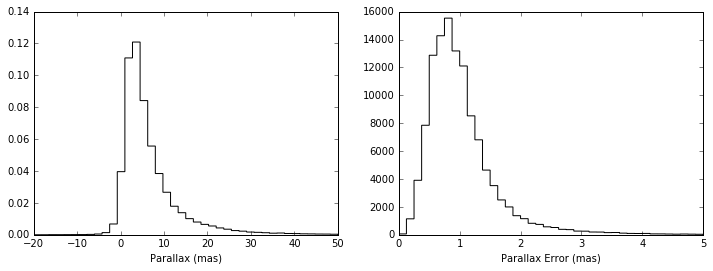

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(hip['Plx'], histtype='step', color='k', bins=40, range=(-20, 50), normed=True)
ax[1].hist(hip['e_Plx'], histtype='step', color='k', bins=40, range=(0, 5))

ax[0].set_xlabel('Parallax (mas)')
ax[1].set_xlabel('Parallax Error (mas)')

plt.show()

### Now, let's select all rNLTT stars with Hipparchos numbers

In [8]:
t_hip_tmp = t_full[np.where(t_full['HIP']!=0)[0]]

# Only non-repeating entries
vals, indices = np.unique(t_hip_tmp['NLTT'], return_index=True)
t_hip = t_hip_tmp[indices]


dtype = [('ID','i8'),('NLTT','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('B','f8'),('V','f8'), \
         ('plx','f8'),('plx_err','f8')]

t = np.zeros(len(t_hip), dtype=dtype)
t['ID'] = t_hip['HIP']
t['NLTT'] = t_hip['NLTT']
t['ra'] = t_hip['ra']
t['dec'] = t_hip['dec']
t['mu_ra'] = t_hip['mu_ra']
t['mu_dec'] = t_hip['mu_dec']
t['mu_ra_err'] = t_hip['mu_ra_err']
t['mu_dec_err'] = t_hip['mu_dec_err']
t['B'] = t_hip['B']
t['V'] = t_hip['V']

# Get parallaxes, by first finding indices matching two catalogs
idx = np.zeros(len(t_hip), dtype='i8')
for i in np.arange(len(t_hip)):
    idx[i] =int(np.where(t_hip[i]['HIP'] == hip['HIP'])[0][0])
    
t['plx'] = hip['Plx'][idx]
t['plx_err'] = hip['e_Plx'][idx]

In [9]:
print len(t_full), len(t)

36085 8288


### The stellar position probability

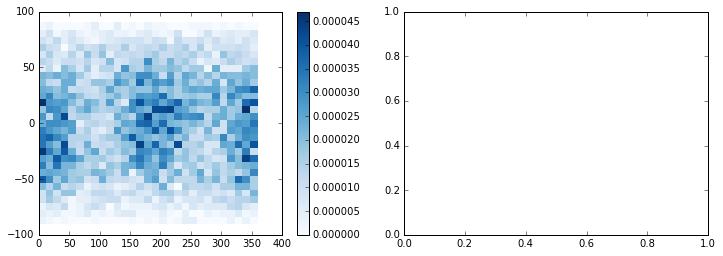

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

nbins = 30
xmin, xmax = 0.0, 360.0
ymin, ymax = -90.0, 90.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
grid = np.array([X.flatten(), Y.flatten()]).T

pdf, xedges, yedges = np.histogram2d(t['ra'], 
                                     t['dec'], 
                                     normed=True,
                                     bins=[xbins,ybins])

im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues')
fig.colorbar(im, ax=ax[0])


P_random.pos_kde = None
Z = P_random.get_sigma_pos(X.flatten(), Y.flatten(), catalog=t, method='kde')

# im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', extend='max')
# fig.colorbar(im, ax=ax[1])

plt.show()